In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Loading Data**

### Backscattered SIF

In [5]:
# Backscatterd SIF master data 
bs_df = pd.read_csv("../Data/raw_data/exp0_df_bs_v2.csv")

# extracting hyperspectral data from band  661 to 850 nm 
sif_X = bs_df.iloc[:,bs_df.columns.get_loc("661"):]

# target variable
y = bs_df[["YPSII"]]

# merging sif_X and y
sif_dataset = pd.concat([sif_X,y], axis=1, join='outer')

## **Exploratory Data Analysis**

### Negative SIF values

Negative SIF bands are not considered for the modeling because negative values are not valid and are caused by low
signal and instrument noise.

In [6]:
# extracting negative SIF bands
bands_negative_values = sif_X.columns[(sif_X < 0).any()]
count_of_negative = ((sif_X[bands_negative_values] < 0)[bands_negative_values]).sum()

# drop bands with negative values
sif_X = sif_X.drop(bands_negative_values, axis=1)

# concatenate sif_X with y
sif_dataset = pd.concat([sif_X,y], axis=1, join='outer')

### SIF dynamic nature

SIF values depend on the light conditions. The section examines dynamic behaviour of SIF w.r.t light conditions.

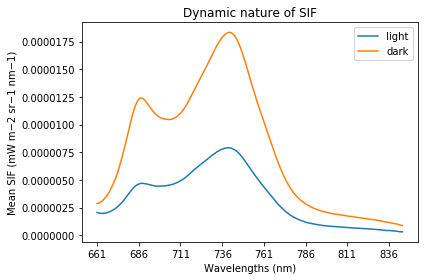

In [7]:
# concatenate sif_X with a column represnting light conditions
sif_treatment = sif_X.combine_first(bs_df[["Treatment"]])
sif_treatment["Treatment"] = sif_treatment["Treatment"].map({"ligh":"light", "dark":"dark"})

# subsetting dataframe w.r.t. light conditions
sif_treatment_light = sif_treatment[sif_treatment.Treatment == "light"]
sif_treatment_dark = sif_treatment[sif_treatment.Treatment == "dark"]

# plotting SIF values for light and dark conditions
sif_treatment_light.mean(axis=0).plot(label="light")
sif_treatment_dark.mean(axis=0).plot(label="dark")
plt.legend()
plt.xlabel("Wavelengths (nm)")
plt.ylabel("Mean SIF (mW m−2 sr−1 nm−1)")
plt.title("Dynamic nature of SIF")
plt.tight_layout()
plt.savefig("Dynamic nature of SIF.png", dpi=1000)
plt.show()

It can be seen that SIF is higher in dark condition, indicating plants are relaxed and vice versa for very bright condition.

### YPSII vs Treatment type

This sections examines distribution of target variable w.r.t light conditions.

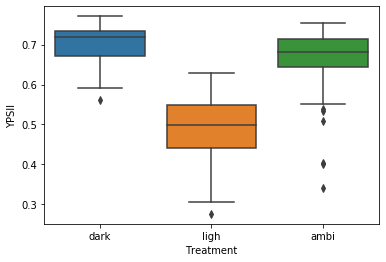

In [8]:
# dataframe containing YPSII and light treatment columns
ypsii_treatment = bs_df[["YPSII", "Treatment"]]

# comparing distribution of YPSII w.r.t. treatment types
sns.boxplot(x="Treatment", y="YPSII", data=ypsii_treatment)

It can be observed that YPSII values are higher in low-light (dark) conditions and lower in bright (light) condition. This indicates YPSII is sensitive to light conditions. 

### Multicollinearity

Such hyperspectral data are usually highly correlated with each other. This section exmaines their correlation.

In [9]:
# finding pairwise correlation among sif_X columns
corr_df = sif_X.corr()

# converting the corr_df to lower triangular matrix
corr_df_lower_triangular = pd.DataFrame(data = np.tril(corr_df), columns=corr_df.columns, index=corr_df.index)

# identify minimum correlation
print("Minimum correlation : ",np.min(corr_df.values))

Minimum correlation :  0.8186581438543189


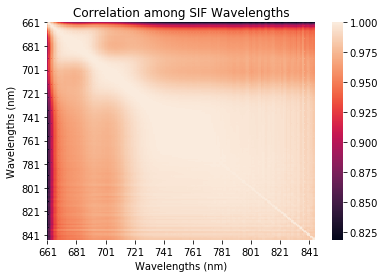

In [10]:
# Heatmap illustrating correlation among SIF bands
sns.heatmap(corr_df)
plt.xticks(range(0, len(corr_df.columns)+1, 20),corr_df.columns[::20], rotation=0)
plt.yticks(range(0, len(corr_df.columns)+1, 20),corr_df.columns[::20])
plt.title("Correlation among SIF Wavelengths")
plt.xlabel("Wavelengths (nm)")
plt.ylabel("Wavelengths (nm)")
plt.savefig("Inter-correlation of SIF Wavelengths", dpi=1000)
plt.show()


### Distribution of YPSII

This section examines distribution of YPSII using density plot. 

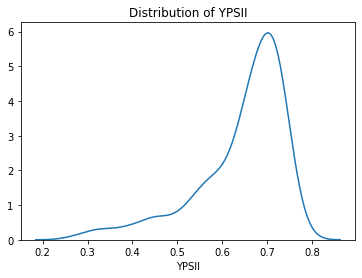

In [11]:
# plotting distribution of YPSII
sns.distplot(sif_dataset["YPSII"], hist=False)
plt.title("Distribution of YPSII")
plt.savefig("YPSII_histogram", dpi=1000)
plt.show()

The density plot is highly negatively skewed. Skewness can create trouble in machine model predictions. Hence, I decided to discreatize the feature into four regions using quartiles. During train-test split, data will be sampled in a stratified manner from these quartile regions. The following graph illustrates the quartile regions. 

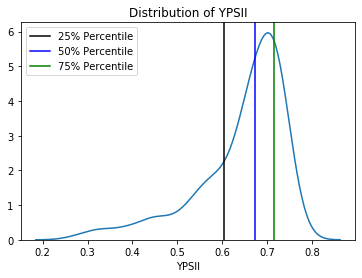

In [12]:
# extarcting quartiles of YPSII
y_quantiles = y.quantile([0.25, 0.5, 0.75]).values

# plotting quartiles along with distribution of YPSII
sns.distplot(sif_dataset["YPSII"], hist=False)
plt.title("Distribution of YPSII")
plt.axvline(y_quantiles[0] , c="black", label="25% Percentile")
plt.axvline(y_quantiles[1] , c="blue", label="50% Percentile")
plt.axvline(y_quantiles[2] , c="green", label="75% Percentile")
plt.legend()
plt.savefig("YPSII_histogram_quantiles", dpi=1000)
plt.show()


## Export pre-processed data

In [25]:
# export the pre-processed data as .csv
sif_dataset.to_csv("../Data/preprocessed_data/exp0_df_bs_v2.csv")